# Taking a quick look on the data

The objective is to quickly gather a series of information on the data we are looking at

In [2]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from anytree import Node, RenderTree
from typing import Dict, List

What are the shapes of the data we are working? 
- We are assuming (30000, 31) for train data and (300, 1259) for target data
- Since test dataset is not labeled we will most likely use a test set and dev set taken from the training set. Selected data should be taken with a specific sampling technique that we will discuss later

In [3]:
training_dataset = './data/train_data/*'
test_dataset = './data/test_data/*'


# Access training ids
training_paths_raw = glob(training_dataset)
training_ids_raw = [path.split('/')[-1] for path in training_paths_raw]
training_ids_raw = [path.split('\\')[-1] for path in training_ids_raw]

# Access test ids
test_paths = glob(test_dataset)
test_ids = [path.split('/')[-1] for path in test_paths]
test_ids = [path.split('\\')[-1] for path in test_ids]

print(f'We are working with {len(training_ids_raw)} training examples')
print(f'We are working with {len(test_ids)} test examples')



We are working with 2000 training examples
We are working with 150 test examples


Let us take a look on what is inside each id

In [4]:
training_sample = os.listdir(training_paths_raw[0])
training_sample

['receiver_data_src_1.npy',
 'receiver_data_src_150.npy',
 'receiver_data_src_225.npy',
 'receiver_data_src_300.npy',
 'receiver_data_src_75.npy',
 'vp_model.npy']

--- 
Let us confirm all data has the appropiate shape

In [6]:
for i in range(len(training_paths_raw)):
    assert np.load(os.path.join(training_paths_raw[i], f'receiver_data_src_1.npy')).shape == (10001, 31)
    assert np.load(os.path.join(training_paths_raw[i], f'receiver_data_src_75.npy')).shape == (10001, 31)
    assert np.load(os.path.join(training_paths_raw[i], f'receiver_data_src_150.npy')).shape == (10001, 31)
    assert np.load(os.path.join(training_paths_raw[i], f'receiver_data_src_225.npy')).shape == (10001, 31)
    assert np.load(os.path.join(training_paths_raw[i], f'receiver_data_src_300.npy')).shape == (10001, 31)
    assert np.load(os.path.join(training_paths_raw[i], f'vp_model.npy')).shape == (300, 1259)

---
Let us find out the data type of every file


In [7]:
training_sample = np.load(os.path.join(training_paths_raw[0], f'receiver_data_src_1.npy'))
target_sample = np.load(os.path.join(training_paths_raw[0], f'vp_model.npy'))
print(f'The dtype of a training instance is: {training_sample.dtype}')
print(f'The dtype of a training label is: {target_sample.dtype}')



The dtype of a training instance is: float32
The dtype of a training label is: float64


Training instances are single float precision, while labels are expected to be double float precision

---
Before comencing exploratory data analysis we must decide strategy on train/test split <br>
While ThinkOnward provides test and train data I will try to engage in a different strategy that will allow us a much easier understanding of the model performance 

---

## Train Test Split

As said before we are working with 2000 training examples and 150 test examples. With this in mind we will follow the next strategy:

- Choosing an split ratio on the training set
- Picking a random seed so our results can be reproducible
- Shuffle our training indices
- Partition into train/validation set
- Sanity check

What are the possible problems with this approach? <br>
- If the dataset gets updated, then the solution will be broken since we will have a new mix of train/validation instances.
- Prone to sampling bias if the chosen validation examples are not representative of the whole training examples.



In [8]:
# Split ratio: 
# 80% -> Training set
# 20% -> Validation set
import numpy as np

def shuffle_and_split_data(data, val_ratio):
    """
    Shuffles a list of folder paths and splits it into training and validation subsets.

    Parameters
    ----------
    data : list of str
        List of folder paths, where each folder contains data samples for training or validation.
    
    val_ratio : float
        The proportion of the data to allocate to the validation set. Must be between 0 and 1.

    Returns
    -------
    train_data : list of str
        Shuffled list of folder paths to be used for training.

    val_data : list of str
        Shuffled list of folder paths to be used for validation.

    Notes
    -----
    A fixed random seed (18) is used for reproducibility.
    """
    np.random.seed(18)
    shuffled_indices = np.random.permutation(len(data))
    val_set_size = int(len(data) * val_ratio)
    val_indices = shuffled_indices[:val_set_size]
    train_indices = shuffled_indices[val_set_size:]
    return  [data[i] for i in train_indices], [data[i] for i in val_indices]

training_ids, validation_ids = shuffle_and_split_data(training_ids_raw, 0.2)


---
Now we need to run a sanity check to see if our approach did not sample bias the train set

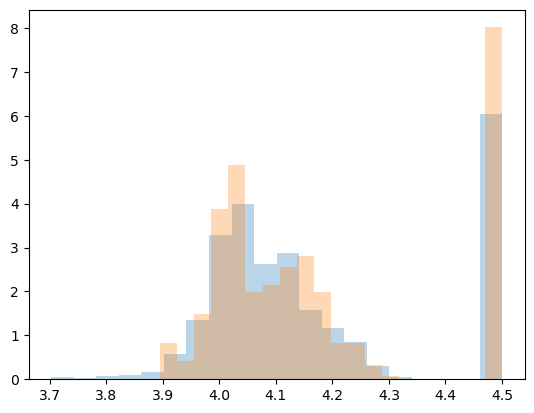

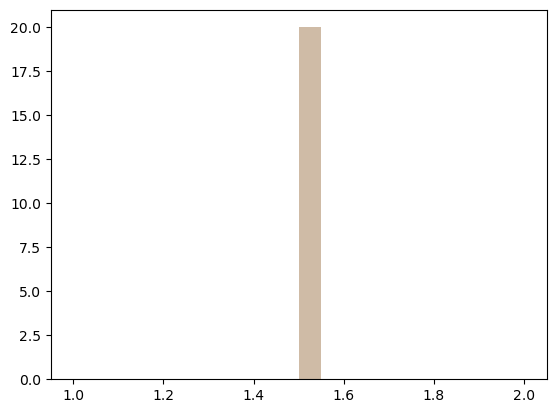

In [16]:
# First we will compute a histogram of our maximum values within each vp_model in the training set vs the validation set
#target_sample = np.load(os.path.join(training_paths_raw[0], f'vp_model.npy'))

def compute_max_velocity(data):
    values = [np.load(f'./data/train_data/{id}/vp_model.npy').max() for id in data]
    return values

def compute_min_velocity(data):
    values = [np.load(f'./data/train_data/{id}/vp_model.npy').min() for id in data]
    return values

def compare_histograms(values: list, num_bins: int):
    kwargs = dict(histtype = 'stepfilled', alpha = 0.3, density = True, bins = num_bins)
    for val in values:
        plt.hist(val, **kwargs);
    plt.show()

        

max_values_train_set = compute_max_velocity(training_ids)
max_values_val_set = compute_max_velocity(validation_ids)

min_values_train_set = compute_min_velocity(training_ids)
min_values_val_set = compute_min_velocity(validation_ids)

compare_histograms(values = [max_values_train_set, max_values_val_set], num_bins=20)
compare_histograms(values = [min_values_train_set, min_values_val_set], num_bins=20)



We can observe that the random split did not introduce any skewness to the data, and both histograms containing min and max values look similar. We can confidently move forward with this train/val split. <br>

What can we improve?
- Compare the mean and standard deviation and compare distributions
- Approximate finite differences and compute a mean absolute gradient per split
- For each shot calculate RMS amplitude and compare train/val histograms
- **Peak amplitude, I Believe this is worth persuing**: Track max(|d|) per gather. If val has far higher peaks, it may represent stronger reflections (i.e. different geology).
- Kolmogorov-Smirnov on mean vp